In [141]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from utils import plot_images_full, generate_matrix, batch_dirichlet, get_similarities, plot_similarities, get_differences, plot_differences, get_images, plot_images

from models.vit import ViT, SimpleViT, SimpleViTI, SimpleViTFT

from sklearn.metrics.pairwise import cosine_similarity

In [298]:
def image_to_graph(image, a_type="grid"):
    n = image.size(2)  # dimension of the grid
    A = torch.zeros((n*n, n*n))  # initialize adjacency matrix
    X = image.flatten(2).transpose(1,2)
    X = X.double()
    
    if a_type == "attention":
        A = torch.nn.functional.softmax(torch.normal(0,1,(n*n,n*n)),0)
        A = A.double()
        return X, A
    
    if a_type == "grid":
        for i in range(n):
            for j in range(n):
                idx = i * n + j  # index of current pixel
                if i > 0:
                    # connect to top neighbor
                    A[idx, idx - n] = 1
                if i < n - 1:
                    # connect to bottom neighbor
                    A[idx, idx + n] = 1
                if j > 0:
                    # connect to left neighbor
                    A[idx, idx - 1] = 1
                if j < n - 1:
                    # connect to right neighbor
                    A[idx, idx + 1] = 1
    elif a_type == "distance":
        for i in range(n):
            for j in range(n):
                idx1 = i * n + j  # index of current pixel
                for k in range(n):
                    for l in range(n):
                        idx2 = k * n + l  # index of current pixel
                        distance = (i-k)**2 + (j-l)**2
                        A[idx1,idx2] = distance
    elif a_type == "dot":
        for i in range(n):
            for j in range(n):
                idx1 = i * n + j  # index of current pixel
                for k in range(n):
                    for l in range(n):
                        idx2 = k * n + l  # index of current pixel
                        distance = (image[:,:,i,j].T.squeeze()@image[:,:,k,l].squeeze()).mean()
                        A[idx1,idx2] = distance
    elif a_type == "nonlocal":
        for i in range(n):
            for j in range(n):
                idx1 = i * n + j  # index of current pixel
                for k in range(n):
                    for l in range(n):
                        idx2 = k * n + l  # index of current pixel
                        distance = ((image[:,:,i,j].squeeze() - image[:,:,k,l].squeeze())**2).mean()
                        A[idx1,idx2] = distance

    elif a_type == "full":
        A = torch.ones((n*n,n*n)) - torch.eye(n*n)
    elif a_type == "random":
        A = torch.normal(0,1,(n*n,n*n))
        A = 0.5*(A+A.T)
        A = (A>0).int()
    else: print("wrong type")
    
    A = A/A.sum(0)
    A = A.double()
                
    return X, A


In [299]:
batch_size = 1
size = 32
patch_size = 1
depth = 128
dim = 3
device = 'cpu'
data_path = './data/'

In [300]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [301]:
def generate_matrix(dim,sign=1):
    Wp = torch.normal(0,0.1,(dim,dim))
    W0 = 0.5*(Wp+Wp.T)
    W = sign* W0@W0.T
    return W.double()

def diffusion_step(F,A,W,tau=1):
    return tau*torch.einsum('kv,nvd -> nkd',A,torch.einsum('nvd,dk -> nvk',F,W)) + F

def diffusion_stepFT(F,A,W,tau=0.5):
    return tau*torch.einsum('kv,nvd -> nkd',A,torch.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

def diffusion_stepI(F,A,W,tau=1):
    return tau*torch.einsum('kv,nvd -> nkd',A-torch.eye(A.shape[0]),torch.einsum('nvd,dk -> nvk',F,W)) + F

def diffusion_stepIFT(F,A,W,tau=0.5):
    return tau*torch.einsum('kv,nvd -> nkd',A-torch.eye(A.shape[0]),torch.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

In [302]:
#image = next(iter(val_loader))[0].to(device)

X0,A = image_to_graph(image,"dot")

As = [A]*depth

W = generate_matrix(dim,-1)
#W = torch.eye(dim)
#W = scipy.special.softmax(np.random.normal(0,0.1,(dim,dim)), axis=1)/dim
#W = scipy.special.softmax(generate_matrix(dim,-1), axis=1)/dim

W = W.double()
Ws = [W]*depth

In [303]:
print(np.linalg.eig(W)[0])
print(W)

[-0.06003216 -0.02804587 -0.02081358]
tensor([[-0.0489,  0.0151,  0.0051],
        [ 0.0151, -0.0330, -0.0074],
        [ 0.0051, -0.0074, -0.0269]], dtype=torch.float64)


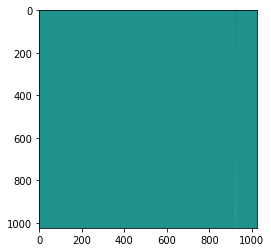

In [304]:
plt.imshow(A)

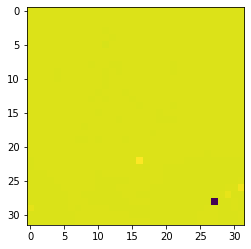

In [305]:
plt.imshow(A[0,:].reshape(32,32))

In [306]:
model_bases = {
    'A':diffusion_step,
    'I':diffusion_stepI,
    'FT':diffusion_stepFT,
    'IFT':diffusion_stepIFT
}

def get_output(x0,method):
    outputs = [x0]
    
    for A,W in zip(As,Ws):
        outputs.append(model_bases[method](outputs[-1],A,W))
            
    return outputs

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [307]:
outputs = get_output(X0,'A')

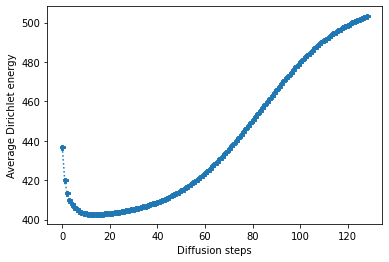

In [308]:
dirichlet_input = [x/np.linalg.norm(x) for x in outputs]
similarities = get_similarities(dirichlet_input)
plot_similarities(similarities)

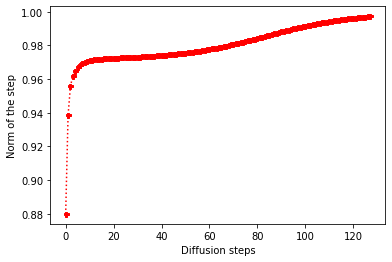

In [309]:
differences = get_differences(outputs)
plot_differences(differences)

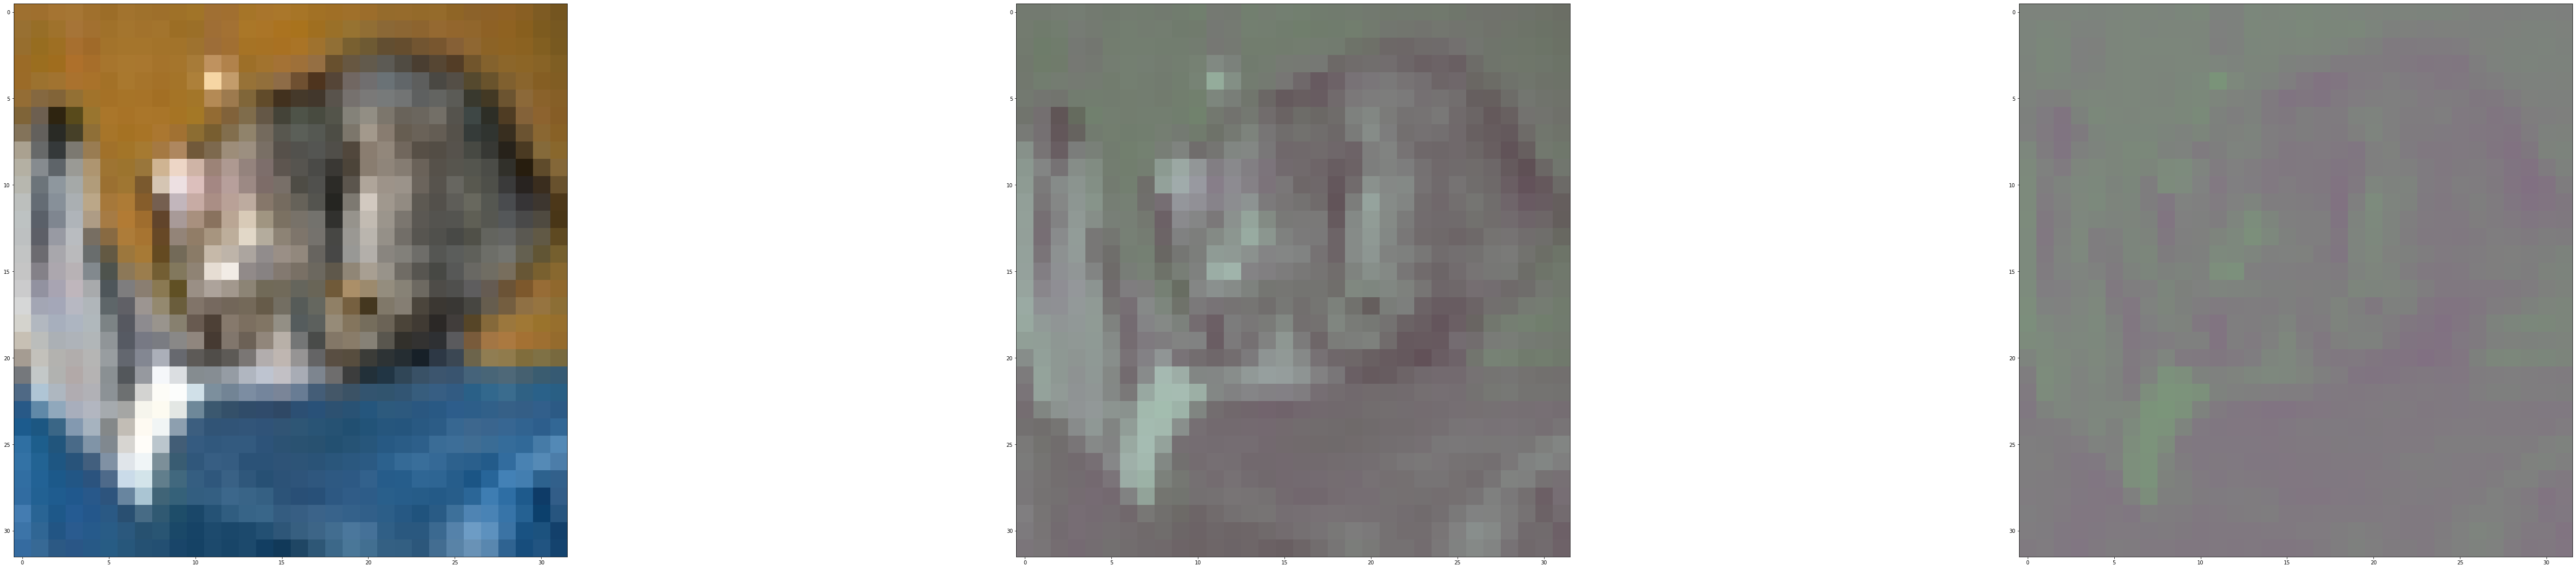

In [311]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images_full([images[0],images[32],images[-1]])

## $\mathbf{F}(t+1) = \tau \bar{\mathbf{A}}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [224]:
outputs = get_output(X0,'I')

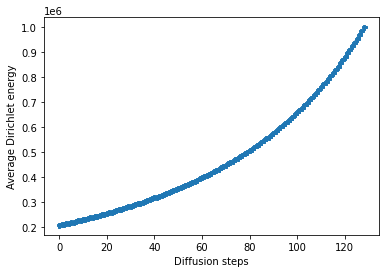

In [225]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

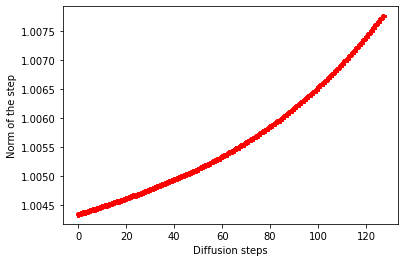

In [226]:
differences = get_differences(outputs)
plot_differences(differences)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


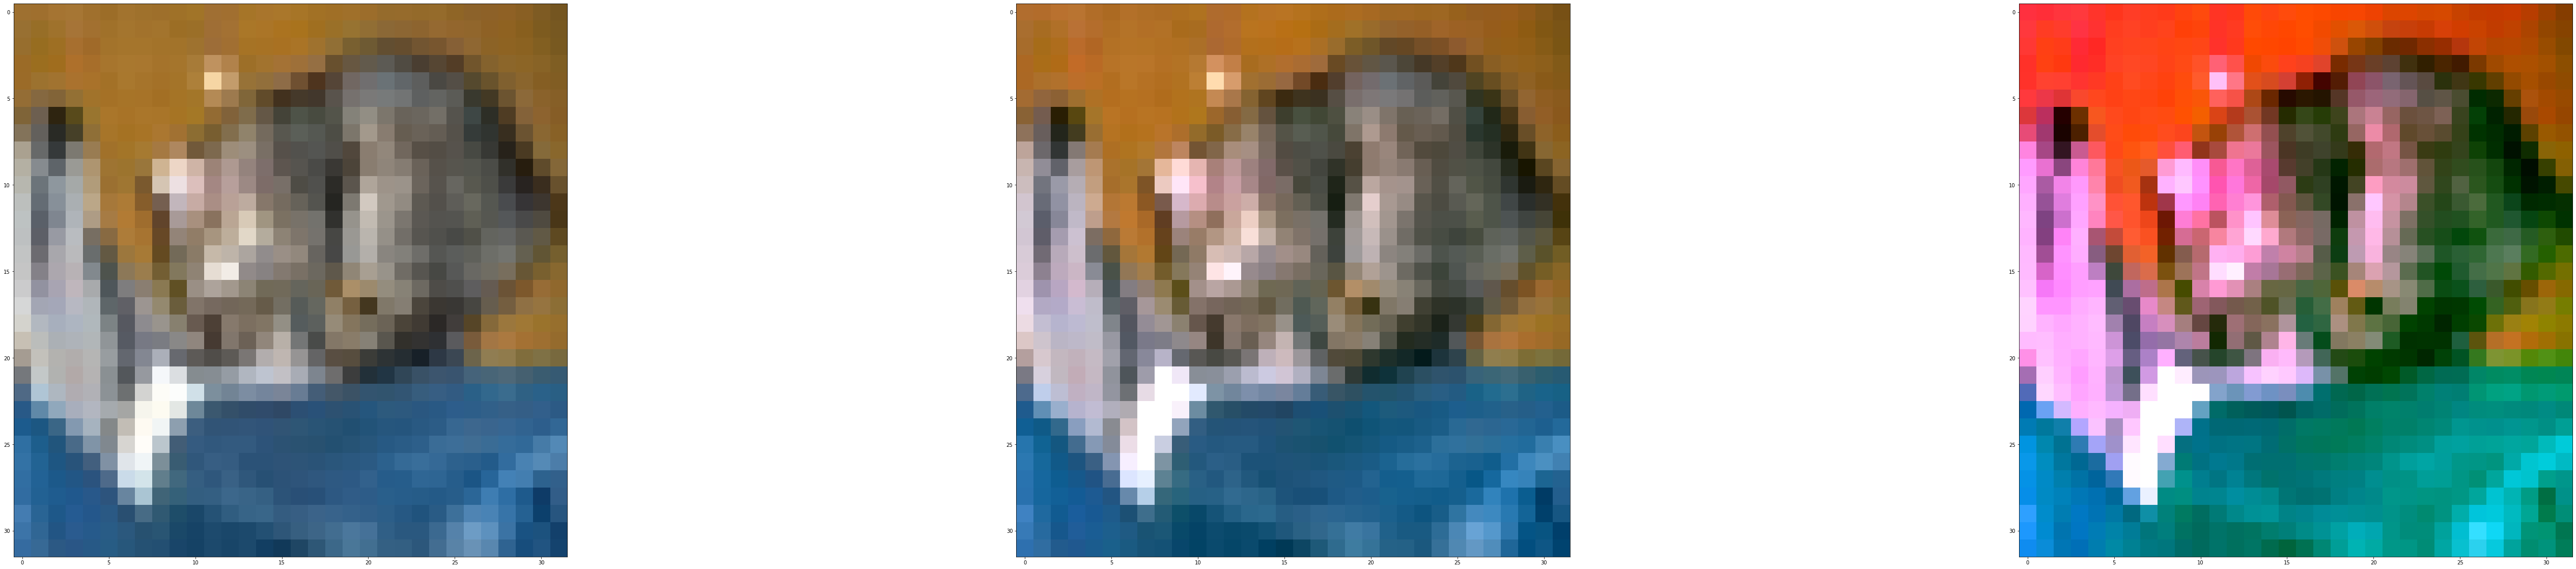

In [227]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images_full([images[0],images[32],images[-1]])

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + (1 - \tau) \mathbf{F}(t)$

In [228]:
outputs = get_output(X0,'FT')

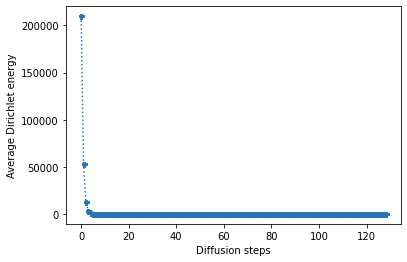

In [229]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

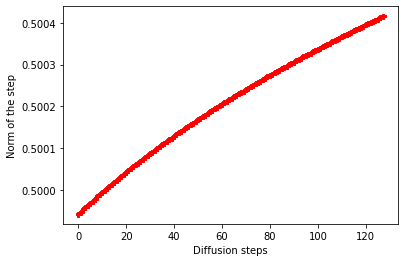

In [230]:
differences = get_differences(outputs)
plot_differences(differences)

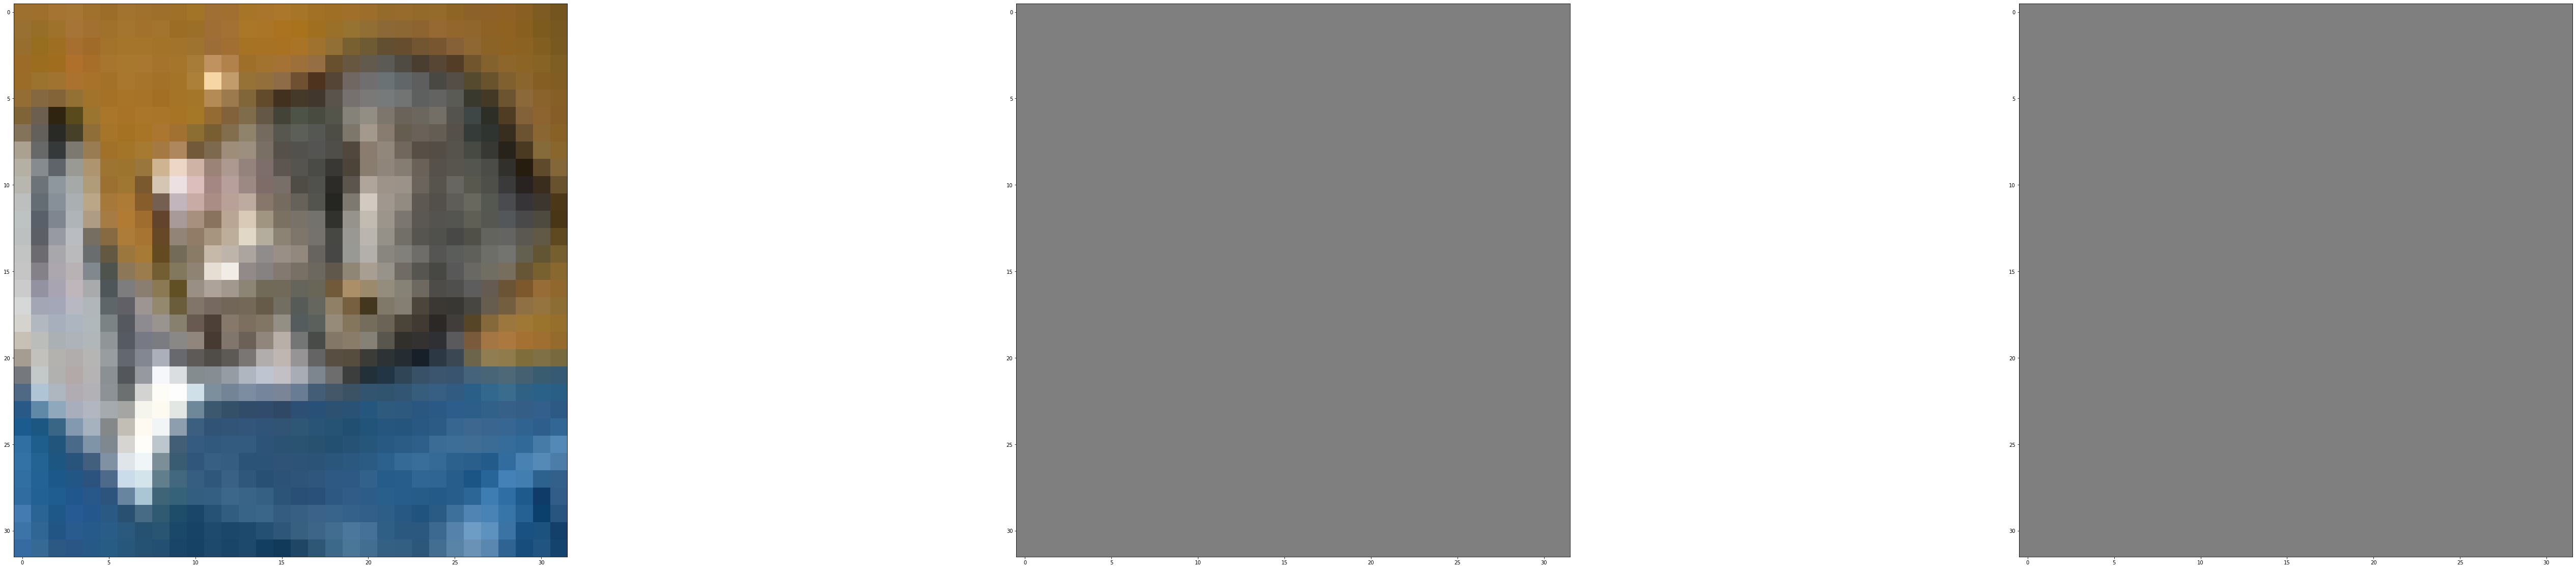

In [231]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images_full([images[0],images[32],images[-1]])